## Bike sharing challenge
#### author: "Evgeniya Vorontsova"
#### date: "January 3, 2021"


* Data exploration

We have 3 tables with the data, and we need to merge them. About the stations table: some stations were moved, but I checked that they were moved very close to the previous spot, so I decided to assume that such stations remain under the old Id, to take into account the previous data about the trips. Also I replaced Cities with its Zip code in the Stations table (for future merge with a Weather table). 
The main part of the job is to create a new table with a net rate data. For that I used Pandas SQL-like functions groupby and count().

* Methods

Four different methods were implemented for the prediction of the net stock of bikes: 1) Linear regression; 2) Random forest; 3) Simple neural network (perceptron); 4) Time Series Autoregressive Moving Average. 

* Performance of the models
> 1. RMSE for Linear regression: 2.982108693411918
> 2. RMSE for Random forest: 2.951517824659255
> 3. RMSE for Neural network: 2.9815951369995526
> 4. RMSE for ARIMA: 3.267484387684325

Example of the predictions with ARIMA model for one of the stations:
![Alt](pred.png "ARIMA predictions (in red)")

* Conclusion

After comparing the results it is clear that there is no best model. So we need to improve one of the current model or to suggest a new one. There are a lot of things that could be done, the details are in the Potential improvements section.

* Potential improvements

> 1. Separate Customers from Subscribers. Usage practice of bike renting for the Subscribers and for the Customers may differ significantly, so it could be better to split this dataset and to predict the net rate independently for them, and then add up these predictions for each of the stations. And maybe weather conditions can affect Customers, but not Subscribers.
> 2. Weather Conditions. Are they really correlated with the net rate or not? This needs to be investigated.
> 3. Parameters for ARIMA model are not the best, it is necessary to find the right ones.
> 4. Neural networks model. I tried only the simple one, but there are at least 2 different types of neural networks that can give better predictions for that case: RNN and convolutional neural network (CNN).
> 5. Try a model with Poisson regression. Very often the net rate can be described with a Poisson distribution.
> 6. Define for the dates if it was a working day or week-end / holiday. The usage practice for these kinds of days are different, and it could be an important additional feature.

* Appendix (Jupyter notebook with code, pictures and other details)


## Appendix

In [1]:
import pandas as pd
import numpy as np

### Data exploration

#### 1. Trips

In [2]:
trips=pd.read_csv("trip_data.csv")
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354152 entries, 0 to 354151
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Trip ID          354152 non-null  int64 
 1   Start Date       354152 non-null  object
 2   Start Station    354152 non-null  int64 
 3   End Date         354152 non-null  object
 4   End Station      354152 non-null  int64 
 5   Subscriber Type  354152 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.2+ MB


In [3]:
trips.head()

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type
0,913460,31/08/2015 23:26,50,31/08/2015 23:39,70,Subscriber
1,913459,31/08/2015 23:11,31,31/08/2015 23:28,27,Subscriber
2,913455,31/08/2015 23:13,47,31/08/2015 23:18,64,Subscriber
3,913454,31/08/2015 23:10,10,31/08/2015 23:17,8,Subscriber
4,913453,31/08/2015 23:09,51,31/08/2015 23:22,60,Customer


#### 2. Stations

In [4]:
stations=pd.read_csv("station_data.csv")
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Id          76 non-null     int64  
 1   Name        76 non-null     object 
 2   Lat         76 non-null     float64
 3   Long        76 non-null     float64
 4   Dock Count  76 non-null     int64  
 5   City        76 non-null     object 
dtypes: float64(2), int64(2), object(2)
memory usage: 3.7+ KB


In [5]:
stations.head()

,Id,Name,Lat,Long,Dock Count,City
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose


##### 2.1 Some stations were moved, but I checked that they were moved very close to the previous spot, so I decided to assume that such stations remain under the old Id, to take into account the previous data about the trips.    

In [6]:
moving_dict = {85: 23, 86: 25, 87: 49, 88: 69, 89: 72, 90: 72}

# To check whether the replacement will be correct
print(trips[trips['Start Station'] == 87].head())
print(trips[trips['End Station'] == 90].head())
for new_st, old_st in moving_dict.items():
    #print(new_st, old_st)
    trips['Start Station'] = np.where(trips['Start Station'] == new_st, old_st, trips['Start Station'])
    trips['End Station'] = np.where(trips['End Station'] == new_st, old_st, trips['End Station'])

# To check whether the replacement was correct    
print(trips[trips['Trip ID'] == 913432])
print(trips[trips['Trip ID'] == 913329])

    Trip ID        Start Date  Start Station          End Date  End Station  \
17   913432  31/08/2015 21:16             87  31/08/2015 21:28           88   
26   913409  31/08/2015 20:44             87  31/08/2015 20:52           61   
44   913379  31/08/2015 20:15             87  31/08/2015 20:28           65   
60   913344  31/08/2015 19:55             87  31/08/2015 20:01           42   
98   913290  31/08/2015 19:18             87  31/08/2015 19:23           61   

   Subscriber Type  
17      Subscriber  
26      Subscriber  
44      Subscriber  
60      Subscriber  
98      Subscriber  
     Trip ID        Start Date  Start Station          End Date  End Station  \
68    913329  31/08/2015 19:42             75  31/08/2015 19:51           90   
107   913281  31/08/2015 19:12             65  31/08/2015 19:19           90   
284   913039  31/08/2015 17:48             42  31/08/2015 18:02           90   
285   913038  31/08/2015 17:48             65  31/08/2015 17:54           90   

In [7]:
stations_old = stations[stations['Id'] < 85]


##### 2.2 Drop unnecessary columns

In [8]:
stations = stations_old[['Id', 'City', 'Dock Count']]

##### 2.3 Replace Cities with its Zip code (for future merge with Weather table)

In [9]:
zip_dict = {'Mountain View': 94041, 'San Jose': 95113, 'Redwood City': 94063, 'Palo Alto': 94301, 'San Francisco': 94107}
for city, ind in zip_dict.items():
    stations.loc[:, 'City'] = np.where(stations['City'] == city, ind, stations['City']) 
stations.loc[:, 'City'] = stations.City.apply('int64')

C:\Users\JaneN\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


#### 3. Weather

In [10]:
weather=pd.read_csv("weather_data.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       1825 non-null   object 
 1   Max TemperatureF           1821 non-null   float64
 2   Mean TemperatureF          1821 non-null   float64
 3   Min TemperatureF           1821 non-null   float64
 4   Max Dew PointF             1775 non-null   float64
 5   MeanDew PointF             1775 non-null   float64
 6   Min DewpointF              1775 non-null   float64
 7   Max Humidity               1775 non-null   float64
 8   Mean Humidity              1775 non-null   float64
 9   Min Humidity               1775 non-null   float64
 10  Max Sea Level PressureIn   1824 non-null   float64
 11  Mean Sea Level PressureIn  1824 non-null   float64
 12  Min Sea Level PressureIn   1824 non-null   float64
 13  Max VisibilityMiles        1820 non-null   float

In [11]:
weather.head()

,Date,Max TemperatureF,Mean TemperatureF,Min TemperatureF,Max Dew PointF,MeanDew PointF,Min DewpointF,Max Humidity,Mean Humidity,Min Humidity,...,Mean VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Mean Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees,Zip
0,01/09/2014,83.0,70.0,57.0,58.0,56.0,52.0,86.0,64.0,42.0,...,10.0,8.0,16.0,7.0,20.0,0.0,0.0,NaN,290.0,94107
1,02/09/2014,72.0,66.0,60.0,58.0,57.0,55.0,84.0,73.0,61.0,...,10.0,7.0,21.0,8.0,NaN,0.0,5.0,NaN,290.0,94107
2,03/09/2014,76.0,69.0,61.0,57.0,56.0,55.0,84.0,69.0,53.0,...,10.0,10.0,21.0,8.0,24.0,0.0,4.0,NaN,276.0,94107
3,04/09/2014,74.0,68.0,61.0,57.0,57.0,56.0,84.0,71.0,57.0,...,10.0,8.0,22.0,8.0,25.0,0.0,5.0,NaN,301.0,94107
4,05/09/2014,72.0,66.0,60.0,57.0,56.0,54.0,84.0,71.0,57.0,...,9.0,7.0,18.0,8.0,32.0,0.0,4.0,NaN,309.0,94107


##### Some columns ("Mean Temperature", etc) depend on others, so they can be dropped. It is better to use "Precipitation" instead of "Events" because it gives the exact amount.

In [12]:
weather = weather.drop(columns=['Mean TemperatureF', 'MeanDew PointF', 'Mean Humidity', 'Mean Sea Level PressureIn', 'Mean VisibilityMiles', 'Mean Wind SpeedMPH', 'Events'])
weather.head()

,Date,Max TemperatureF,Min TemperatureF,Max Dew PointF,Min DewpointF,Max Humidity,Min Humidity,Max Sea Level PressureIn,Min Sea Level PressureIn,Max VisibilityMiles,Min VisibilityMiles,Max Wind SpeedMPH,Max Gust SpeedMPH,PrecipitationIn,CloudCover,WindDirDegrees,Zip
0,01/09/2014,83.0,57.0,58.0,52.0,86.0,42.0,29.86,29.76,10.0,8.0,16.0,20.0,0.0,0.0,290.0,94107
1,02/09/2014,72.0,60.0,58.0,55.0,84.0,61.0,29.87,29.79,10.0,7.0,21.0,NaN,0.0,5.0,290.0,94107
2,03/09/2014,76.0,61.0,57.0,55.0,84.0,53.0,29.81,29.72,10.0,10.0,21.0,24.0,0.0,4.0,276.0,94107
3,04/09/2014,74.0,61.0,57.0,56.0,84.0,57.0,29.81,29.72,10.0,8.0,22.0,25.0,0.0,5.0,301.0,94107
4,05/09/2014,72.0,60.0,57.0,54.0,84.0,57.0,29.92,29.81,10.0,7.0,18.0,32.0,0.0,4.0,309.0,94107


In [13]:
# Replace NaN values in Max Gust Column with the corresponding values from Max Wind Column
weather['Max Gust SpeedMPH'].fillna(weather['Max Wind SpeedMPH'], inplace=True)

In [14]:
weather['Date'] = pd.to_datetime(weather['Date'])

#### 4. Merge Trips and Stations

In [15]:
result = pd.merge(trips, stations, how='inner', left_on='Start Station', right_on='Id')
result.rename(columns={'City': 'Start City'}, inplace = True)
result.drop(columns=['Id'], inplace = True)
result = pd.merge(result, stations, how='inner', left_on='End Station', right_on='Id')
result.rename(columns={'City': 'End City'}, inplace = True)
result.drop(columns=['Id'], inplace = True)

# Let's check if some people travel by bike between different cities
print(len(result[(result['Start City'] != result['End City'])]))

# Convert dates to the right format
result['Start Date'] = pd.to_datetime(result['Start Date'], format="%d/%m/%Y %H:%M")  

result['End Date'] = pd.to_datetime(result['End Date'], format="%d/%m/%Y %H:%M")
result.info()

509
<class 'pandas.core.frame.DataFrame'>
Int64Index: 354152 entries, 0 to 354151
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Trip ID          354152 non-null  int64         
 1   Start Date       354152 non-null  datetime64[ns]
 2   Start Station    354152 non-null  int64         
 3   End Date         354152 non-null  datetime64[ns]
 4   End Station      354152 non-null  int64         
 5   Subscriber Type  354152 non-null  object        
 6   Start City       354152 non-null  int64         
 7   Dock Count_x     354152 non-null  int64         
 8   End City         354152 non-null  int64         
 9   Dock Count_y     354152 non-null  int64         
dtypes: datetime64[ns](2), int64(7), object(1)
memory usage: 29.7+ MB


#### 5. Create a new Dataframe with Net Rate Answers

In [16]:
result

,Trip ID,Start Date,Start Station,End Date,End Station,Subscriber Type,Start City,Dock Count_x,End City,Dock Count_y
0,913460,2015-08-31 23:26:00,50,2015-08-31 23:39:00,70,Subscriber,94107,23,94107,19
1,913228,2015-08-31 18:47:00,50,2015-08-31 19:02:00,70,Subscriber,94107,23,94107,19
2,913009,2015-08-31 17:40:00,50,2015-08-31 17:53:00,70,Subscriber,94107,23,94107,19
3,912956,2015-08-31 17:31:00,50,2015-08-31 17:48:00,70,Subscriber,94107,23,94107,19
4,912776,2015-08-31 16:50:00,50,2015-08-31 17:04:00,70,Subscriber,94107,23,94107,19
...,...,...,...,...,...,...,...,...,...,...
354147,623899,2015-01-29 14:44:00,23,2015-01-29 14:51:00,26,Subscriber,94063,15,94063,15
354148,623793,2015-01-29 12:44:00,23,2015-01-29 13:01:00,26,Subscriber,94063,15,94063,15
354149,607173,2015-01-16 12:15:00,23,2015-01-16 12:28:00,26,Subscriber,94063,15,94063,15
354150,600300,2015-01-12 12:52:00,23,2015-01-12 13:05:00,26,Subscriber,94063,15,94063,15


In [17]:
# Before Group by we need to remove minutes from Dates columns, because we need to group by the trips within each hour
result['Start Date'] = result['Start Date'].dt.round('H')
result['End Date'] = result['End Date'].dt.round('H')

trips_begin_gr = result.groupby(['Start Date', 'Start Station'])['Trip ID'].count()
# The same with End Date
trips_end_gr = result.groupby(['End Date', 'End Station'])['Trip ID'].count()

# Now we need to merge them (before we create Dataframes from one-column Series)
trips_begin_gr = trips_begin_gr.reset_index()
trips_end_gr = trips_end_gr.reset_index()
trips_begin_gr.columns = ['Start Date', 'Id Station', 'Number of Starts']
trips_end_gr.columns = ['Start Date', 'Id Station', 'Number of Ends']
df_net_rate = trips_begin_gr.merge(trips_end_gr, on=['Start Date', 'Id Station'], how='outer')

df_net_rate

,Start Date,Id Station,Number of Starts,Number of Ends
0,2014-09-01 00:00:00,66,3.0,NaN
1,2014-09-01 03:00:00,50,1.0,NaN
2,2014-09-01 04:00:00,39,1.0,NaN
3,2014-09-01 05:00:00,66,1.0,NaN
4,2014-09-01 06:00:00,68,1.0,NaN
...,...,...,...,...
198250,2015-08-31 23:00:00,27,NaN,1.0
198251,2015-08-31 23:00:00,60,NaN,2.0
198252,2015-08-31 23:00:00,64,NaN,1.0
198253,2015-08-31 23:00:00,70,NaN,1.0


In [18]:
# Well, we have a lot of NaNs. Let's replace them with 0
df_net_rate.fillna(0, inplace = True)

In [19]:
# The net rate of bikes renting
df_net_rate['Net Rate'] = df_net_rate['Number of Ends'] - df_net_rate['Number of Starts']

df_net_rate_all = df_net_rate.merge(stations, left_on='Id Station', right_on='Id')
df_net_rate_all = df_net_rate_all.drop(columns=['Id', 'Number of Starts', 'Number of Ends'])
df_net_rate_all

,Start Date,Id Station,Net Rate,City,Dock Count
0,2014-09-01 00:00:00,66,-3.0,94107,19
1,2014-09-01 05:00:00,66,-1.0,94107,19
2,2014-09-01 09:00:00,66,-1.0,94107,19
3,2014-09-01 12:00:00,66,-2.0,94107,19
4,2014-09-01 14:00:00,66,-3.0,94107,19
...,...,...,...,...,...
198250,2015-08-26 19:00:00,26,1.0,94063,15
198251,2015-08-27 07:00:00,26,1.0,94063,15
198252,2015-08-27 09:00:00,26,1.0,94063,15
198253,2015-08-28 09:00:00,26,1.0,94063,15


In [20]:
# Merge with Weather Conditions. Before we need to create a new column Date (without hours)
df_net_rate_all['Date Only'] = df_net_rate_all['Start Date'].dt.round('D')

df_net_rate_all_w = pd.merge(df_net_rate_all, weather,  how='left', left_on=['Date Only','City'], right_on = ['Date','Zip'])
df_net_rate_all_w = df_net_rate_all_w.drop(columns=['Date Only', 'Date', 'Zip'])

### Modelling approach

#### Model 1 Regression

In [21]:
from statsmodels.api import OLS
from statsmodels.api import add_constant

X = df_net_rate_all_w.drop(columns = ['Net Rate'])
X.fillna(0, inplace = True)
X['Start Date'] = pd.to_timedelta(X['Start Date'] - pd.to_datetime('01/09/2014 00:00'))
X['Start Date'] = X['Start Date'].dt.total_seconds()
X['Start Date'] = X['Start Date'].values.astype('int')
X = np.asarray(X, dtype = 'float')
y = df_net_rate_all_w['Net Rate'].values

# Divide the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)#,random_state = 46)

# First model is Regression
X_train_c = add_constant(X_train)
ols = OLS(y_train, X_train_c)
model1 = ols.fit()
print(model1.summary())

X_test_c = add_constant(X_test)
y_pred = model1.predict(X_test_c)

from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(y_pred, y_test, squared = False)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9812
Date:                Sun, 03 Jan 2021   Prob (F-statistic):              0.480
Time:                        12:06:51   Log-Likelihood:            -3.9511e+05
No. Observations:              158604   AIC:                         7.903e+05
Df Residuals:                  158584   BIC:                         7.905e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8354      2.952      0.283      0.7

##### Regression results are not good, so we need to try other models. 

#### Model 2 Random Forest

In [22]:
# Finding best hyperparameters for Random Forest
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor()
RF_params = {'n_estimators': np.arange(10, 100, 20), 'max_depth': np.arange(1, 11, 3), 'min_samples_leaf': np.arange(3, 10, 3)}

from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(RF, RF_params, cv=5)
gs.fit(X_train, y_train)
b = gs.best_params_
print(b)

{'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 70}


#### Model 3 Neural Network (Perceptron)

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# For Multi-layer Perceptron we need to normalize the data before
mlp = make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes=(10, 10), tol=1e-3, max_iter=500))
model3 = mlp.fit(X_train, y_train)

#### Model 4 Time Series ARMA Autoregressive Moving Average

In [24]:
df_net_rate_all

,Start Date,Id Station,Net Rate,City,Dock Count,Date Only
0,2014-09-01 00:00:00,66,-3.0,94107,19,2014-09-01
1,2014-09-01 05:00:00,66,-1.0,94107,19,2014-09-01
2,2014-09-01 09:00:00,66,-1.0,94107,19,2014-09-01
3,2014-09-01 12:00:00,66,-2.0,94107,19,2014-09-01
4,2014-09-01 14:00:00,66,-3.0,94107,19,2014-09-02
...,...,...,...,...,...,...
198250,2015-08-26 19:00:00,26,1.0,94063,15,2015-08-27
198251,2015-08-27 07:00:00,26,1.0,94063,15,2015-08-27
198252,2015-08-27 09:00:00,26,1.0,94063,15,2015-08-27
198253,2015-08-28 09:00:00,26,1.0,94063,15,2015-08-28


In [25]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [26]:
ts_all = df_net_rate_all[['Start Date', 'Id Station', 'Net Rate']]
ts_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198255 entries, 0 to 198254
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Start Date  198255 non-null  datetime64[ns]
 1   Id Station  198255 non-null  int64         
 2   Net Rate    198255 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 6.1 MB


In [27]:
# We need to train this model independentely for each bike station, so the Id of the station should be an input parameter
Id_Station = 50

ts_one_st = ts_all[ts_all['Id Station'] == Id_Station]
ts_one_st = ts_one_st.drop(columns=['Id Station'])
ts_one_st

,Start Date,Net Rate
4169,2014-09-01 03:00:00,-1.0
4170,2014-09-01 11:00:00,-1.0
4171,2014-09-01 12:00:00,4.0
4172,2014-09-01 13:00:00,3.0
4173,2014-09-01 14:00:00,0.0
...,...,...
9540,2015-08-30 13:00:00,2.0
9541,2015-08-30 14:00:00,1.0
9542,2015-08-30 15:00:00,1.0
9543,2015-08-30 19:00:00,1.0


In [28]:
# Then we need to add missing rows, with hours when nothing happens at the station. And fill them with 0 net rate
df_all_hours = pd.DataFrame(columns=['Date'])
df_all_hours['Date'] = pd.date_range(start = '2014-09-01 00:00', end='2015-09-01 00:00', freq='H')
ts_ready = pd.merge(df_all_hours, ts_one_st, how='outer', left_on='Date', right_on='Start Date')
ts_ready.fillna(0, inplace=True)
ts_ready = ts_ready.drop(columns=['Start Date'])
ts_ready.set_index('Date', inplace=True)
ts_ready

,Net Rate
Date,
2014-09-01 00:00:00,0.0
2014-09-01 01:00:00,0.0
2014-09-01 02:00:00,0.0
2014-09-01 03:00:00,-1.0
2014-09-01 04:00:00,0.0
...,...
2015-08-31 20:00:00,0.0
2015-08-31 21:00:00,1.0
2015-08-31 22:00:00,0.0


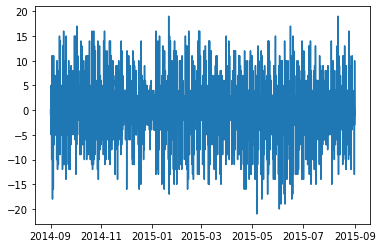

In [29]:
import matplotlib.pyplot as plt
plt.plot(ts_ready.index, ts_ready.values)

                               SARIMAX Results                                
Dep. Variable:               Net Rate   No. Observations:                 8761
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -23164.200
Date:                Sun, 03 Jan 2021   AIC                          46336.400
Time:                        13:44:59   BIC                          46364.712
Sample:                    09-01-2014   HQIC                         46346.047
                         - 09-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4256      0.008    -55.052      0.000      -0.441      -0.410
ar.L2         -0.2453      0.008    -29.281      0.000      -0.262      -0.229
ar.L3         -0.1439      0.010    -15.093      0.0

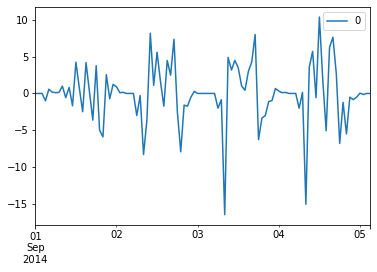

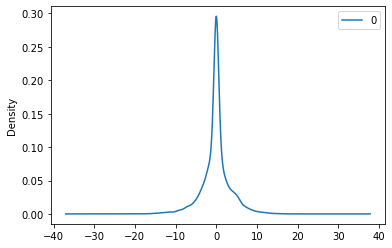

                  0
count  8.761000e+03
mean  -3.215836e-05
std    3.405399e+00
min   -1.827687e+01
25%   -1.088754e+00
50%    1.774317e-52
75%    1.021430e+00
max    1.914388e+01


In [30]:
from statsmodels.tsa.arima.model import ARIMA

ts_ready.index = pd.DatetimeIndex(ts_ready.index.values, freq = ts_ready.index.inferred_freq)
# First parameter -- 3 hours
ar = ARIMA(ts_ready, order=(3, 1, 0))
model4 = ar.fit()
print(model4.summary())
# Plot of residuals
residuals = pd.DataFrame(model4.resid)
residuals.iloc[:100].plot()
plt.show()
# Density Plot of residuals
residuals.plot(kind='kde')
plt.show()
# Statistics for residuals
print(residuals.describe())

##### It looks no so bad, and Mean is almost equal to 0, and the residial errors are Gaussian, so we can try to use this model.

In [31]:
X = ts_ready

# Divide the data into train and test
size = int(0.8*len(X))
X_train_arm, X_test_arm = X[0:size], X[size:len(X)]
predicted_list = list()
len_X_test = len(X_test_arm)

# On each iteration we add a new real value into X_test_arm and train the model again
for i in range(len_X_test):
    ar = ARIMA(X_train_arm, order=(3, 1, 0))
    model4 = ar.fit()
    predicted = model4.forecast()
    yhat = predicted[0]
    predicted_list.append(yhat)
    real = X_test_arm.iloc[i]
    X_train_arm = X_train_arm.append(real)
    #print("Predicted = ", yhat, "; real = ", real[0])

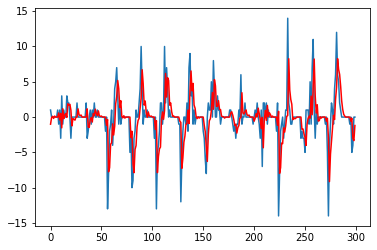

In [32]:
# Blue -- real values, red -- predicted values
plt.plot(X_test_arm[:300].values)
plt.plot(predicted_list[:300], color='red')
plt.show()

### Performance analysis

In [35]:
print('1. RMSE for Linear regression:', rmse1)

# Fitting the model with best params
RF = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'])
model2 = RF.fit(X_train, y_train)
y_pred = model2.predict(X_test)
rmse2 = mean_squared_error(y_pred, y_test, squared = False)
print('2. RMSE for Random forest:', rmse2)

y_pred = model3.predict(X_test)
rmse3 = mean_squared_error(y_pred, y_test, squared = False)
print('3. RMSE for Neural network:', rmse3)

rmse4 = mean_squared_error(X_test_arm, predicted_list, squared = False) 
#print('Test RMSE: %.3f' % rmse)
print('4. RMSE for ARIMA model:', rmse4)

1. RMSE for Linear regression: 2.982108693411918
2. RMSE for Random forest: 2.9505531867818595
3. RMSE for Neural network: 2.9815951369995526
4. RMSE for ARIMA model: 3.267484387684325


### Conclusions

##### Four different methods were implemented for the prediction of the net stock of bikes: 1) Linear regression; 2) Random forest; 3) Neural network (perceptron); 4) Time Series Autoregressive Moving Average. 
##### After comparing the results it is clear that there is no best model. So we need to improve one of the current model or to suggest a new one. There are a lot of things that could be done, the details are in the next section.

### Potential improvements

###### 1. Separate Customers from Subscribers. Usage practice of bike renting for the Subscribers and for the Customers may differ significantly, so it could be better to split this dataset and to predict the net rate independently for them, and then add up these predictions for each of the stations. And maybe weather conditions can affect Customers, but not Subscribers.
###### 2. Weather Conditions. Are they really correlated with the net rate or not? This needs to be investigated.
###### 3. Parameters for ARIMA model are not the best, it is necessary to find the right ones.
###### 4. Neural networks model. I tried only the simple one, but there are at least 2 different types of neural networks that can give better predictions for that case: RNN and convolutional neural network (CNN).
###### 5. Try a model with Poisson regression. Very often the net rate can be described with a Poisson distribution.
###### 6. Define for the dates if it was a working day or week-end / holiday. The usage practice for these kinds of days are different, and it could be an important additional feature.
